#CS733: Module 2 Assignment: Multi-class Sentiment Analysis (SA)

AJ Broderick *(UIN 01244170)* \
abrod006@odu.edu \

##Import Libraries & Read Data

In [ ]:
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

import re
import nltk
from nltk.util import ngrams
from nltk import word_tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()
nltk.download('wordnet')
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer(strip_handles=True)

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


&emsp; Connect to GoogleDrive and read csv file that was downloaded from Kaggle containing the 1.6million tweets. The file didn't have headers when downloaded, so had to use `header=None` to ensure Python didn't attempt to use first record as the header. To make coding easier and know what column was which, renamed column headers using information from Kaggle page.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

df = DataFrame(pd.read_csv("/content/drive/MyDrive/CS 733/Data/training.1600000.processed.noemoticon.csv",header=None,encoding='latin-1'))
df = df.rename(columns={
    0: "target",
    1: "id",
    2: "date",
    3: "flag",
    4: "user",
    5: "text"})

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Data Exploration

&emsp; Similar to Assignment 1, a brief data exploration was performed on the DataFrame that was created. From the info output, can see that all 1.6million records were read in successfully and there were no records with missing data, so no data cleaning would be needed to continue.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


&emsp; Quick bar chart was created on the `target` column, to see the number of tweets in the DataFrame that had positive (4) and negative (0) sentiments. From the chart, it could be seen that there was an equal split in the known sentiment, which is good as it prevented class imbalance when creating and training the models later on.

<BarContainer object of 2 artists>

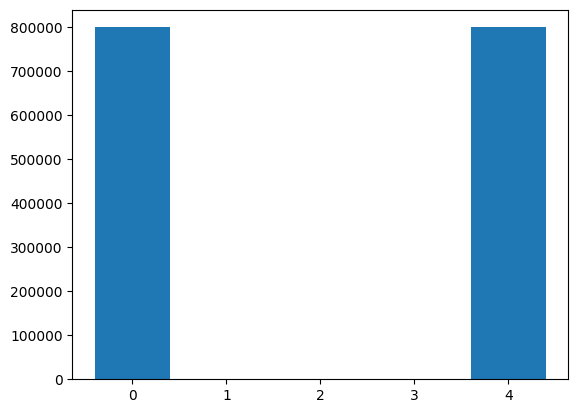

In [ ]:
plt.bar(df['target'].unique(), df.groupby(['target'])['id'].count())

##Task 1: Data Preprocessing

&emsp; Given that there is a large dataset to work with, the data needs to be preprocessed before feeding it into the models. One of first things that is done is to utilize a package from nltk, specifically `TweetTokenizer(strip_handles=True)`. With this package it can remove all of the Twitter handles that might be found in the tweets themselves. By doing this, it creates a smaller dictionary of words, since there is a chance that a single twitter handle will appear in only one tweet. \
&emsp; The remainder of the processing is similar to what was done in the first assignment, including the following:
*   Remove Stop Words
*   Lemmatize the words in the corpus
*   Make all words lowercase

In [ ]:
def clean_text(text):
  text = tokenizer.tokenize(text)
  text = re.sub('[^a-zA-Z ]', '', str(text))
  text = text.lower()
  text = nltk.word_tokenize(text)
  stop_words = set(stopwords.words('english'))
  text = [word for word in text if word not in stop_words]
  return ' '.join([wnl.lemmatize(words) for words in text])

&emsp; Apply `clean_text` function to the DataFrame to replace the text column

In [ ]:
df['text'] = df['text'].map(clean_text)

In [ ]:
df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,httptwitpiccomyzl awww thats bummer shoulda go...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset cant update facebook texting might cry r...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dived many time ball managed save rest go bound
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feel itchy like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,behaving im mad cant see


In [ ]:
#df.to_csv('/content/drive/MyDrive/CS 733/Data/training.1600000.processed.noemoticon.cleaned.csv', index=False)

##Task 2: Feature Engineering

###TF_DIF

&emsp; TF-DIF was chosen as the feature extraction method for the sentiment analysis. This was done over a bag of words approach since it's a little more nuanced in the way that each of the words is given a weight as opposed to simply counting the words. In a model of this size, the words that have the higher frequency will have a larger impact to the end output.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
vectorizer = TfidfVectorizer()
X_vector = vectorizer.fit_transform(df['text'])

&emsp; Print the overall shape of the vectorized data, can see the 1.6million records, and that there is 344,117 words in the dictionary that were included in the vector. Also wanted to look at the array of the vector, and here it can be seen that there are some very unusual *'words'* in the vector, including *'zzzzzzzzzzzzzzzzzzz'*.

In [ ]:
print(X_vector.shape)

(1600000, 344117)


In [ ]:
vectorizer.get_feature_names_out()

array(['aa', 'aaa', 'aaaa', ..., 'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz',
       'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz',
       'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz'],
      dtype=object)

&emsp; To try to refine the vector, the `max_features` was utilized from `TfidVectorizer` to remove the lower third of the features. This was done to remove words that only appear in one or two tweets, which should improve the overall performance of the modeling.

In [ ]:
vectorizer = TfidfVectorizer(max_features = 228117)
X_vector = vectorizer.fit_transform(df['text'])

In [ ]:
print(X_vector.shape)

(1600000, 228117)


In [ ]:
vectorizer.get_feature_names_out()

array(['aa', 'aaa', 'aaaa', ..., 'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz',
       'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz',
       'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz'], dtype=object)

###Split Train

&emsp; To create the models, the data is split into the training set and the testing set. To ensure that a good representation of all of the new headlines, an additional input of the `train_test_split` is included. This input is the `stratify` function. By including it, and applying it to the column for the news headline sentiment, and using a test size of 20%, the training data will include loop through each of the sentiments and pull 80% of each to use in the training set.

In [ ]:
y = df['target']

vectorizer = TfidfVectorizer(max_features = 228117)
X_vector = vectorizer.fit_transform(df['text'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_vector, y, test_size = 0.2, random_state=42, stratify=df['target'])

##Task 3: Naive Bayes Classification

&emsp; Now that the data has been cleaned and the data has been split into the training and test sets, the actual modeling can be done. From the sklearn library there are various different Naive Bayes models are available. It was ultimately decided to import and use the Multinomial Naive Bayes, as it was described in the class and textbook.




In [ ]:
from sklearn.naive_bayes import MultinomialNB
NB_classifier = MultinomialNB()
NB_classifier.fit(X_train, y_train)

MultinomialNB()

&emsp; Once the model was trained, it was tested on the test dataset. The output of the test data was stored in both a classification report along with a confusion matrix, both of which will be evaluated and described later in Task 5.

In [ ]:
nb_target = NB_classifier.predict(X_test)
nb_cr = classification_report(y_test, nb_target)
nb_cm = confusion_matrix(y_test, nb_target, labels=[4, 0])

##Task 4: Logistic Regression Classification

&emsp; The last step that was done before the final analysis was to train and test the Logistic Regression. This was done using the linear_model library from sklearn, and `LogisticRegression` was pulled in to the model. Similar with the previous model, the output from the model was stored in a classification report and a confusion matrix.

In [ ]:
from sklearn.linear_model import LogisticRegression
LR_classifier = LogisticRegression()
LR_classifier.fit(X_train, y_train)

LogisticRegression()

In [ ]:
lr_target = LR_classifier.predict(X_test)
lr_cr = classification_report(y_test, lr_target)
lr_cm = confusion_matrix(y_test, lr_target, labels=[4, 0])

##Task 5: Model Comparison and Analysis

###Performance Metrics

&emsp; Now that both the Naive Bayes and Logistic Regression models were trained and applied to the test dataset, it is now time to evaluate them individually and against one another. The Performance Metric tables for the models that where created in Task 3 & Task 4 are printed to evaluate.

In [ ]:
print("Naive Bayes Classification Report: \n")
print(nb_cr)
print("Logistic Regression Classification Report: \n")
print(lr_cr)

Naive Bayes Classification Report: 

              precision    recall  f1-score   support

           0       0.76      0.78      0.77    160000
           4       0.77      0.75      0.76    160000

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000

Logistic Regression Classification Report: 

              precision    recall  f1-score   support

           0       0.80      0.76      0.78    160000
           4       0.77      0.81      0.79    160000

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



**Naive Bayes**

*   ***Precision*** - For this model, the overall precision was at 77%, meaning that the system detected the positive tweets were in fact positive 77% of the time
*   ***Recall*** - Similarly  the recall on this model was at 77%. Which means that the model rate of items actually present in the input were correctly identified 77% of the time.
*   ***Accuracy*** - Finally, and not surprisingly the accuracy of the Naive Bayes model was 77%. Given there was not a lot of fine tuning of the model, the fact that it was able to predict the sentiment of the tweet 77% of the time is not too bad.

**Logistic Regression**

*   ***Precision*** - 78%
*   ***Recall*** - 78%
*   ***Accuracy*** - 78% \
&emsp; From this there was not a large unpick in the overall performance of the Logistic Regression model compared to the Navies Bayes model.

### Confusion Matrices

&emsp; Another way to evaluate the models was through the use of the Confusion Matrices. Used the information that was created in the previous tasks along with Seaborn heatmapping to create the two Confusion Matrices.

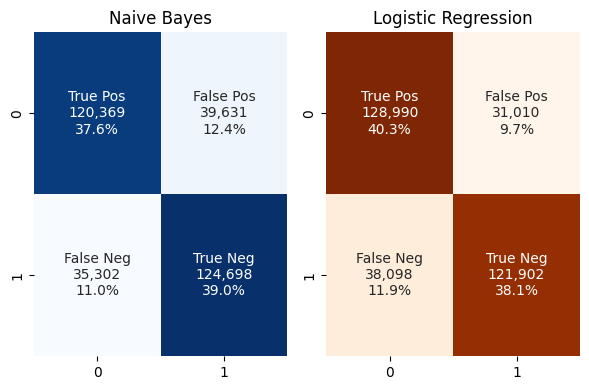

In [ ]:
group_names = ['True Pos','False Pos','False Neg','True Neg']
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6, 4))

# Naive Bayes
nb_group_counts = ["{:,.0f}".format(value) for value in nb_cm.flatten()]
nb_group_percentages = ["{0:.1%}".format(value) for value in nb_cm.flatten()/np.sum(nb_cm)]
nb_labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,nb_group_counts,nb_group_percentages)]
nb_labels = np.asarray(nb_labels).reshape(2,2)
sb.heatmap(nb_cm, annot=nb_labels, fmt='', cmap='Blues', ax=ax1, cbar=False)
ax1.set_title("Naive Bayes")

# Logistic Regression
lr_group_counts = ["{:,.0f}".format(value) for value in lr_cm.flatten()]
lr_group_percentages = ["{0:.1%}".format(value) for value in lr_cm.flatten()/np.sum(lr_cm)]
lr_labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,lr_group_counts,lr_group_percentages)]
lr_labels = np.asarray(lr_labels).reshape(2,2)
sb.heatmap(lr_cm, annot=lr_labels, fmt='', cmap='Oranges', ax=ax2, cbar=False)
ax2.set_title("Logistic Regression")

plt.tight_layout()
plt.show()

### Discussion

&emsp; From the modeling that was done, there wasn't too much of a difference between the two models. The output from the Classification Report showed that they performed pretty much the same, with only a 1% increase in performance in the Logistic Regression model. \
&emsp; One thing to point out though is the difference in the true positives that were displayed in the Confusion Matrices. Whilst the two models looked to have the same performance, the Logistic Regression model did a better job at predicting the true positives. This would lend itself to being the preferred model for trying to find tweets that have an overall postive feel to them. \
&emsp; If the models were to be refined, the feature engineering of the dataset would need to be reworked. Given that there were so many tweets to process, the vectors that were created might have been to broad to predict the sentiment. Even with trying to remove the bottom 1/3 of values in the vector did not seem to increase the models performances. One way that it could be enhanced would be to use the TD-DIF approach combined with a dictionary of positive and negative words. This would create more impactful weights on the words that would be fed into the model.
